In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
import plotly.graph_objects as go
from prophet import Prophet


In [91]:
data = pd.read_csv('./data/processed/data.csv', index_col=0)
data.index = pd.to_datetime(data.index, utc=True)
data.index = pd.date_range(start=data.index[0], periods=len(data), freq='h')

data = data.loc['2022-01-01 00:00:00':'2024-12-30 23:00:00', :].copy()
end_train = '2023-12-31 23:59:00'
end_validation = '2024-11-30 23:59:00'
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()
data_train = data_train.dropna(subset=data_train.columns)

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")



# y_train.index = pd.date_range(start='2020-01-01', periods=len(y_train), freq='h')  # Example hourly data

Train dates      : 2022-01-02 00:00:00+00:00 --- 2023-12-31 23:00:00+00:00  (n=17496)
Validation dates : 2024-01-01 00:00:00+00:00 --- 2024-11-30 23:00:00+00:00  (n=8040)
Test dates       : 2024-12-01 00:00:00+00:00 --- 2024-12-30 23:00:00+00:00  (n=720)


In [7]:
data_train

,demand-mwh,temperature_2m,relative_humidity_2m,apparent_temperature,rain,showers,snowfall,cloud_cover,wind_speed_10m,hour,day,is_weekend,month,demand_lag1,demand_lag2,demand_lag24
2022-01-01 00:00:00+00:00,45943,-14.9355,81.0,-19.768436,0.0,0.0,0.0,7.0,7.704336,18,5,True,12,NaN,NaN,NaN
2022-01-01 01:00:00+00:00,46427,-14.8855,69.0,-19.736115,0.0,0.0,0.0,7.0,7.289445,19,5,True,12,45943.0,NaN,NaN
2022-01-01 02:00:00+00:00,45058,-11.5355,60.0,-16.392967,0.0,0.0,0.0,7.0,7.787991,20,5,True,12,46427.0,45943.0,NaN
2022-01-01 03:00:00+00:00,43430,-7.7855,51.0,-12.334994,0.0,0.0,0.0,7.0,6.193674,21,5,True,12,45058.0,46427.0,NaN
2022-01-01 04:00:00+00:00,42058,-4.2855,43.0,-8.318744,0.0,0.0,0.0,7.0,3.075841,22,5,True,12,43430.0,45058.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00+00:00,42873,-7.9090,46.0,-13.310272,0.0,0.0,0.0,9.0,11.592894,13,7,False,12,43795.0,45091.0,43768.0
2023-12-31 20:00:00+00:00,42496,-8.2090,46.0,-13.696123,0.0,0.0,0.0,19.0,12.096214,14,7,False,12,42873.0,43795.0,42778.0
2023-12-31 21:00:00+00:00,42210,-8.4590,45.0,-14.072976,0.0,0.0,0.0,28.0,12.819235,15,7,False,12,42496.0,42873.0,42288.0
2023-12-31 22:00:00+00:00,42457,-8.7090,45.0,-14.406500,0.0,0.0,0.0,19.0,13.324863,16,7,False,12,42210.0,42496.0,41897.0


In [166]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_train.index, y=data_train['demand-mwh'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=data_val.index, y=data_val['demand-mwh'], mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=data_test.index, y=data_test['demand-mwh'], mode='lines', name='Test'))
fig.update_layout(
    title='Hourly energy demand',
    xaxis_title="Time",
    yaxis_title="Demand",
    legend_title="Partition:",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(orientation="h", yanchor="top", y=1, xanchor="left", x=0.001)
)
#fig.update_xaxes(rangeslider_visible=True)
fig.show()


In [32]:
def seasonal_naive_forecast(y_train, y_test, seasonal_period=168):
    """Seasonal Naive: Forecast = value from same time last season (168h = 1 week)"""
    print("Running Seasonal Naive Model...")

    # Combine for indexing
    y_full = pd.concat([y_train, y_test])
    forecasts = []

    for i in range(len(y_test)):
        current_time = y_test.index[i]
        try:
            past_time = current_time - pd.Timedelta(hours=seasonal_period)
            forecast = y_full.loc[past_time]
        except KeyError:
            # Fallback to last value in y_train
            forecast = y_train.iloc[-1]
        forecasts.append(forecast)

    forecasts = np.array(forecasts)

    # Metrics
    mae = mean_absolute_error(y_test, forecasts)
    mape = mean_absolute_percentage_error(y_test, forecasts)
    rmse = root_mean_squared_error(y_test, forecasts)

    print(f"✅ Seasonal Naive - MAE: {mae:.2f}, MAPE: {mape:.4f}")
    
    return forecasts, {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

In [33]:
naive_forecasts, naive_metrics = seasonal_naive_forecast(data_train['demand-mwh'], data_val['demand-mwh'])

Running Seasonal Naive Model...
✅ Seasonal Naive - MAE: 4671.76, MAPE: 0.0864


In [135]:
def holt_winters_forecast(y_train, y_test):
    """Holt-Winters Exponential Smoothing"""
    print("Running Holt-Winters Model...")
    
    try:

        
        model = ExponentialSmoothing(
            y_train,
            trend='add',
            seasonal='add',
            seasonal_periods=24,  # Daily seasonality for hourly data
            damped_trend=True
        )
        
        fitted_model = model.fit(optimized=True)
        forecasts = fitted_model.forecast(steps=len(y_test))
        
        # Metrics
        rmse = root_mean_squared_error(y_test, forecasts)
        mae = mean_absolute_error(y_test, forecasts)
        mape = mean_absolute_percentage_error(y_test, forecasts)
        
        print(f"Holt-Winters - RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.4f}")
        
        return forecasts, {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'model': fitted_model}
    
    except Exception as e:
        print(f"Holt-Winters failed: {e}")
        return None, None

In [136]:
hw_forecasts, hw_metrics = holt_winters_forecast(data_train['demand-mwh'], data_val['demand-mwh'])

Running Holt-Winters Model...
Holt-Winters - RMSE: 13944.40, MAE: 10049.90, MAPE: 0.1645


In [80]:
def sarimax_forecast(y_train, y_test, train_data=None, test_data=None, weather_features=None):
    """SARIMAX with optional weather features"""
    print("Running SARIMAX Model...")
    
    # Prepare weather data
    exog_train = None
    exog_test = None
    
    if weather_features is not None and train_data is not None:
        exog_train = train_data[weather_features]
        exog_test = test_data[weather_features]
        print(f"   Using weather features: {weather_features}")
    
    # SARIMAX parameters (you can tune these)
    order = (1, 1, 1)  # (p, d, q)
    seasonal_order = (1, 1, 1, 24)  # (P, D, Q, s) - 24h seasonality
    
    try:
        model = SARIMAX(
            y_train,
            exog=exog_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        
        fitted_model = model.fit(disp=False, maxiter=100)
        
        if exog_test is not None:
            forecasts = fitted_model.forecast(steps=len(y_test), exog=exog_test)
        else:
            forecasts = fitted_model.forecast(steps=len(y_test))
        
        # Metrics
        rmse = root_mean_squared_error(y_test, forecasts)
        mae = mean_absolute_error(y_test, forecasts)
        mape = mean_absolute_percentage_error(y_test, forecasts)
        
        print(f"SARIMAX - RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.4f}")
        
        return forecasts, {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'model': fitted_model}
    
    except Exception as e:
        print(f"SARIMAX failed: {e}")
        return None, None

In [99]:
weather_features = ['temperature_2m','relative_humidity_2m','rain','showers','snowfall','cloud_cover','demand_lag1','demand_lag2','demand_lag24']  # Replace with your actual columns

sarimax_forecasts, sarimax_metrics = sarimax_forecast(data_train['demand-mwh'], data_val['demand-mwh'], data_train, data_val, weather_features)

Running SARIMAX Model...
   Using weather features: ['temperature_2m', 'relative_humidity_2m', 'rain', 'showers', 'snowfall', 'cloud_cover', 'demand_lag1', 'demand_lag2', 'demand_lag24']
SARIMAX - RMSE: 20335.00, MAE: 17515.26, MAPE: 0.3148


In [94]:
print(sarimax_metrics['model'].summary())

                                     SARIMAX Results                                      
Dep. Variable:                         demand-mwh   No. Observations:                17496
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood             -127751.081
Date:                            Sat, 26 Jul 2025   AIC                         255518.161
Time:                                    18:22:38   BIC                         255580.296
Sample:                                01-02-2022   HQIC                        255538.625
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
demand_lag1      1.4261      0.178      8.023      0.000       1.078       1.775
demand_lag2     -0.4715      

In [82]:
def prophet_forecast(y_train, y_test, train_data=None, test_data=None, weather_features=None):
    print("Running Prophet Model...")

    def strip_tz_index(idx):
        idx = pd.to_datetime(idx)
        try:
            return idx.tz_localize(None)
        except TypeError:
            return idx

    # Ensure tz-naive
    y_train = y_train.copy()
    y_test  = y_test.copy()
    y_train.index = strip_tz_index(y_train.index)
    y_test.index  = strip_tz_index(y_test.index)

    if train_data is not None:
        train_data = train_data.copy()
        train_data.index = strip_tz_index(train_data.index)
    if test_data is not None:
        test_data = test_data.copy()
        test_data.index = strip_tz_index(test_data.index)

    prophet_train = pd.DataFrame({'ds': y_train.index, 'y': y_train.values})

    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True,
        seasonality_mode='additive',
        changepoint_prior_scale = .5
    )

    if weather_features is not None and train_data is not None:
        for feature in weather_features:
            model.add_regressor(feature)
            prophet_train[feature] = train_data[feature].values
        print(f"   Using weather features: {weather_features}")

    try:
        model.fit(prophet_train)

        future = pd.DataFrame({'ds': y_test.index})
        if weather_features is not None and test_data is not None:
            for feature in weather_features:
                future[feature] = test_data[feature].values

        forecast = model.predict(future)
        forecasts = forecast['yhat'].values

        rmse = root_mean_squared_error(y_test, forecasts)
        mae = mean_absolute_error(y_test, forecasts)
        mape = mean_absolute_percentage_error(y_test, forecasts)
        peak_demand = y_test.max()
        relative_rmse = rmse / peak_demand

        print(f"Prophet - RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.4f}, Relative RMSE: {relative_rmse:.2f}")

        return forecasts, {'RMSE': rmse, 'MAE': mae, 'MAPE': mape,
                           'model': model, 'forecast_df': forecast}
    except Exception as e:
        print(f"Prophet failed: {e}")
        return None, None


In [83]:
data_train.index = data_train.index.tz_localize(None)
prophet_forecasts, prophet_metrics = prophet_forecast(data_train['demand-mwh'], data_val['demand-mwh'], data_train, data_val)

Running Prophet Model...


18:02:19 - cmdstanpy - INFO - Chain [1] start processing
18:02:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet - RMSE: 8914.22, MAE: 6922.70, MAPE: 0.1327, Relative RMSE: 0.10


In [84]:
weather_features =['hour','day','is_weekend','month', 'demand_lag1','demand_lag2','demand_lag24']
prophet_forecasts, prophet_metrics = prophet_forecast(data_train['demand-mwh'], data_val['demand-mwh'], data_train, data_val, weather_features)

Running Prophet Model...
   Using weather features: ['hour', 'day', 'is_weekend', 'month', 'demand_lag1', 'demand_lag2', 'demand_lag24']


18:02:26 - cmdstanpy - INFO - Chain [1] start processing
18:02:29 - cmdstanpy - INFO - Chain [1] done processing


Prophet - RMSE: 762.49, MAE: 576.70, MAPE: 0.0109, Relative RMSE: 0.01


In [85]:
weather_features =['temperature_2m','relative_humidity_2m','rain','showers','snowfall','cloud_cover','hour','day','is_weekend','month', 'demand_lag1','demand_lag2','demand_lag24']
prophet_forecasts, prophet_metrics = prophet_forecast(data_train['demand-mwh'], data_val['demand-mwh'], data_train, data_val, weather_features)

Running Prophet Model...
   Using weather features: ['temperature_2m', 'relative_humidity_2m', 'rain', 'showers', 'snowfall', 'cloud_cover', 'hour', 'day', 'is_weekend', 'month', 'demand_lag1', 'demand_lag2', 'demand_lag24']


18:02:31 - cmdstanpy - INFO - Chain [1] start processing
18:02:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet - RMSE: 716.41, MAE: 531.61, MAPE: 0.0100, Relative RMSE: 0.01


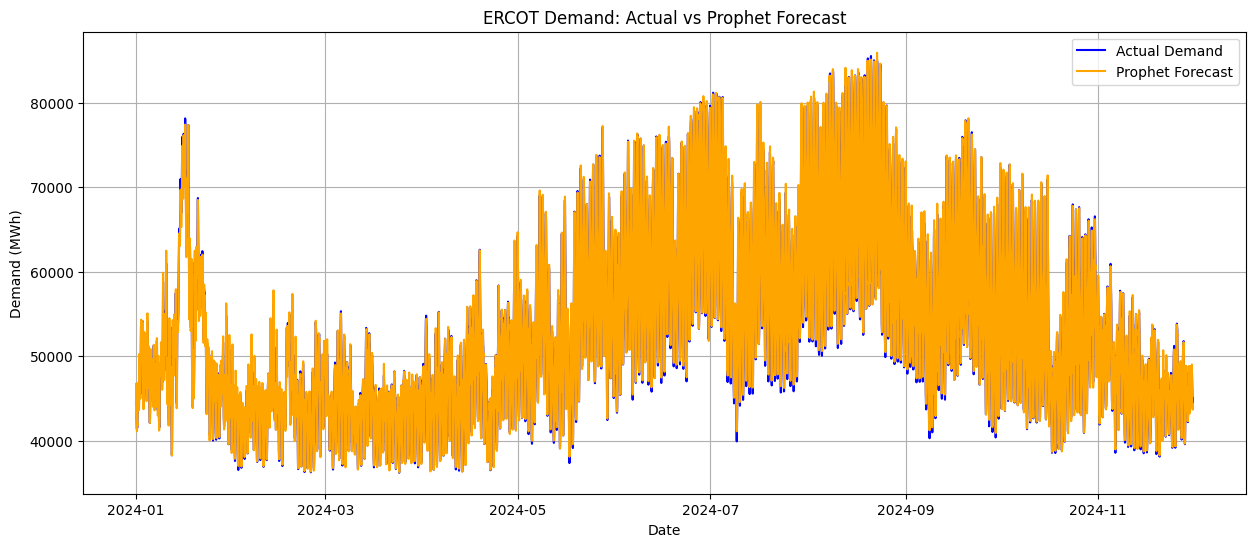

In [67]:


def plot_forecast(y_test, forecast_values):
    plt.figure(figsize=(15,6))
    plt.plot(y_test.index, y_test.values, label='Actual Demand', color='blue')
    plt.plot(y_test.index, forecast_values, label='Prophet Forecast', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Demand (MWh)')
    plt.title('ERCOT Demand: Actual vs Prophet Forecast')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_forecast(data_val['demand-mwh'], prophet_forecasts)

In [75]:
demand_holdout = data_test['demand-mwh']
weather_holdout = data_test[weather_features].copy()
test_data_holdout = weather_holdout.dropna()
y_test_holdout = demand_holdout.loc[test_data_holdout.index]

model = prophet_metrics['model'] 

future_holdout = pd.DataFrame({'ds': y_test_holdout.index})
future_holdout['ds'] = pd.to_datetime(future_holdout['ds']).dt.tz_localize(None)

for feature in weather_features:
    future_holdout[feature] = test_data_holdout[feature].values

forecast_holdout = model.predict(future_holdout)
forecasts_holdout = forecast_holdout['yhat'].values

In [78]:
rmse_holdout = root_mean_squared_error(y_test_holdout, forecasts_holdout)
mae_holdout = mean_absolute_error(y_test_holdout, forecasts_holdout)
mape_holdout = mean_absolute_percentage_error(y_test_holdout, forecasts_holdout)
peak_demand_holdout = y_test_holdout.max()
relative_rmse_holdout = rmse_holdout / peak_demand_holdout

print(f"Holdout Test - RMSE: {rmse_holdout:.2f}, MAE: {mae_holdout:.2f}, MAPE: {mape_holdout:.4f}, Relative RMSE: {relative_rmse_holdout:.2f}")

Holdout Test - RMSE: 587.72, MAE: 419.40, MAPE: 0.0087, Relative RMSE: 0.01
